In [1]:
import pandas as pd
import networkx as nx
import osmnx as ox
import config
import random
import math
import testing.helpers.testing_helper as test_helper
import route_planning.helpers.route_planning_helper as route_helper
import matplotlib.pyplot as plt

In [2]:
G = ox.load_graphml(filepath=f"{config.testing_graphml_path}/merged_routes.graphml")
G

Get sets of generated and real bus stops

In [3]:
%%time
nodes, edges = ox.graph_to_gdfs(G)
nodes = nodes.replace({"True": True, "False": False})
actual_stops = nodes[nodes["actual_stop"] == True]
generated_stops = nodes[(nodes["community_route"] == True) |
                        (nodes["connection_route"] == True)]

CPU times: user 977 ms, sys: 19.8 ms, total: 997 ms
Wall time: 1 s


In [4]:
len(actual_stops)

122

In [5]:
len(generated_stops)

650

Determine sample size to use...

First find the total population:

In [6]:
population_data = pd.read_csv(f"{config.population_data_path}/donegal_townlands_all_coordinates.csv")
total_population = sum(population_data["population"])
total_population

157920.0

And use that number for the Cochran’s theorem calculation:

In [7]:
sample_size = test_helper.sample_size(int(total_population),
                                      margin_error=.05,
                                      confidence_level=.95)
sample_size

383.23017177926187

Round sample size up to 384

In [8]:
sample_size = math.ceil(sample_size)
sample_size

384

Select pseudorandom sample nodes

In [9]:
random.seed(123)
all_stops = actual_stops["osmid"].tolist() + generated_stops["osmid"].tolist()
nodes_to_sample_from = nodes.query("osmid not in @all_stops")["osmid"].tolist()
%time sample_nodes = random.sample(nodes_to_sample_from, sample_size)
sample_nodes

CPU times: user 355 µs, sys: 25 µs, total: 380 µs
Wall time: 386 µs


[2278757178,
 3136051855,
 2907774541,
 807308716,
 1890409027,
 7636067634,
 6268063403,
 1605600061,
 1963769166,
 819185298,
 2101310838,
 795638023,
 3080327970,
 4743968493,
 2025663538,
 6987544489,
 1373292089,
 6268679720,
 2500523458,
 818369564,
 2293512464,
 7636844721,
 3101333914,
 4880014961,
 821219557,
 1954841321,
 3915716742,
 6692012674,
 7768600251,
 1924398741,
 6681239278,
 3881968646,
 3121549346,
 3215269892,
 1878583118,
 4221644835,
 3141085488,
 6700205618,
 1650811944,
 6988339162,
 5195221482,
 3183388882,
 5887580695,
 1883219672,
 1896549990,
 7494396791,
 789477821,
 815118697,
 1886956307,
 3084535531,
 2195641112,
 3158695028,
 2010495763,
 4838442792,
 7768600241,
 2111374311,
 2196540165,
 811392631,
 2004137482,
 3101333787,
 816377862,
 2197929531,
 6988356697,
 2521098012,
 2278477960,
 3153701888,
 795326656,
 1890641877,
 1885442530,
 1886618154,
 777368917,
 3666545673,
 5709684279,
 3218357846,
 7635991734,
 2334923965,
 6257945654,
 316046635

Run the accessibility tests:

In [10]:
%%time

results_list = []
for node in sample_nodes:
    # 20km radius graph around the source node
    graph = nx.generators.ego_graph(G, node, radius=20000, distance="length")

    # get the stops that are in the sub-graph
    nodes = ox.graph_to_gdfs(graph, edges=False)
    nodes = nodes.replace({"True": True, "False": False})
    actual_stops_present = list(set(actual_stops["osmid"]).intersection(nodes["osmid"]))
    gen_stops_present = list(set(generated_stops["osmid"]).intersection(nodes["osmid"]))

    # path to closest actual stop
    actual_stops_shortest_path, actual_stops_shortest_path_weight = \
    test_helper.find_shortest_path_to_destinations(graph,
                                                   node,
                                                   actual_stops_present,
                                                   print_all=False)
    # path to closest generated stop
    gen_stops_shortest_path, gen_stops_shortest_path_weight = \
    test_helper.find_shortest_path_to_destinations(graph,
                                                   node,
                                                   gen_stops_present,
                                                   print_all=False)

    # add to results
    results_list.append({"sample_node": node,
                         "actual_stops_sp": actual_stops_shortest_path,
                         "actual_stops_sp_length": actual_stops_shortest_path_weight,
                         "gen_stops_sp": gen_stops_shortest_path,
                         "gen_stops_sp_length": gen_stops_shortest_path_weight})
results_df = pd.DataFrame(results_list)
results_df

CPU times: user 10min 56s, sys: 825 ms, total: 10min 57s
Wall time: 11min 3s


,sample_node,actual_stops_sp,actual_stops_sp_length,gen_stops_sp,gen_stops_sp_length
0,2278757178,"[2278757178, 2278757361, 2278757246, 227875714...",2245.646,"[2278757178, 2278757361, 2278757277]",832.667
1,3136051855,"[3136051855, 3136051862, 262493600, 1954832010]",120.599,"[3136051855, 3136051862, 262493600, 3181896668]",115.735
2,2907774541,"[2907774541, 1417678818, 2111294458, 141767885...",3478.453,"[2907774541, 1417678818, 1417678805]",1653.475
3,807308716,"[807308716, 807308416, 807307754, 7040259102, ...",1942.705,"[807308716, 807308416, 807307754, 7040259102, ...",1734.323
4,1890409027,"[1890409027, 1890409019, 1890408893, 189040902...",3684.294,"[1890409027, 1890409019, 1890408893, 189040902...",15138.646
...,...,...,...,...,...
379,1876244975,"[1876244975, 1876245440, 2188448320, 320646189...",5867.070,"[1876244975, 1876245440, 1876245281, 773139158]",1267.495
380,1890696165,"[1890696165, 1890697184, 1890696643, 159256307...",5150.666,"[1890696165, 1886644218, 5187149633, 518701145...",2566.956
381,2961981925,"[2961981925, 2961981886, 1875858817, 296198185...",10921.216,"[2961981925, 2961981886, 2961981898, 296200373...",3658.769
382,814508608,"[814508608, 814508418, 814508423, 814508670, 8...",1269.987,"[814508608, 814508418, 814508423, 814508670, 8...",1279.166


In [11]:
results_df.to_csv(f"{config.testing_path}/"
                  f"results/results_seed123.csv")

In [2]:
results_df = pd.read_csv(f"{config.testing_path}/"
                         f"results/results_seed123.csv")
results_df

,Unnamed: 0,sample_node,actual_stops_sp,actual_stops_sp_length,gen_stops_sp,gen_stops_sp_length
0,0,2278757178,"[2278757178, 2278757361, 2278757246, 227875714...",2245.646,"[2278757178, 2278757361, 2278757277]",832.667
1,1,3136051855,"[3136051855, 3136051862, 262493600, 1954832010]",120.599,"[3136051855, 3136051862, 262493600, 3181896668]",115.735
2,2,2907774541,"[2907774541, 1417678818, 2111294458, 141767885...",3478.453,"[2907774541, 1417678818, 1417678805]",1653.475
3,3,807308716,"[807308716, 807308416, 807307754, 7040259102, ...",1942.705,"[807308716, 807308416, 807307754, 7040259102, ...",1734.323
4,4,1890409027,"[1890409027, 1890409019, 1890408893, 189040902...",3684.294,"[1890409027, 1890409019, 1890408893, 189040902...",15138.646
...,...,...,...,...,...,...
379,379,1876244975,"[1876244975, 1876245440, 2188448320, 320646189...",5867.070,"[1876244975, 1876245440, 1876245281, 773139158]",1267.495
380,380,1890696165,"[1890696165, 1890697184, 1890696643, 159256307...",5150.666,"[1890696165, 1886644218, 5187149633, 518701145...",2566.956
381,381,2961981925,"[2961981925, 2961981886, 1875858817, 296198185...",10921.216,"[2961981925, 2961981886, 2961981898, 296200373...",3658.769
382,382,814508608,"[814508608, 814508418, 814508423, 814508670, 8...",1269.987,"[814508608, 814508418, 814508423, 814508670, 8...",1279.166


Actual stops that are closer to sample nodes:

In [13]:
actual_stop_closer = results_df.query("actual_stops_sp_length < "
                                      "gen_stops_sp_length")
len(actual_stop_closer)

112

112 actual stops are closer. Now find the generated stops that are closer:

In [14]:
gen_stop_closer = results_df.query("actual_stops_sp_length > "
                                   "gen_stops_sp_length")
len(gen_stop_closer)

262

262 generated are closer, a difference of 150.

Find the percentage differnce

In [15]:
(len(actual_stop_closer)/len(gen_stop_closer))*100

42.74809160305343

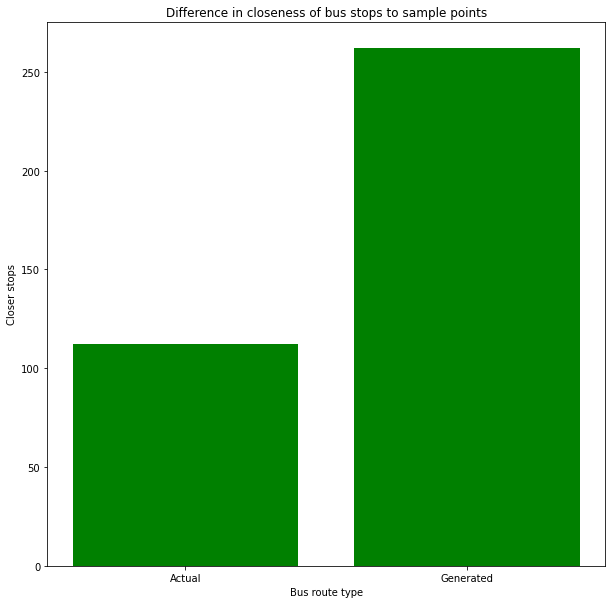

In [16]:
fig = plt.figure(figsize=(10, 10))
x = ['Actual', 'Generated']
energy = [len(actual_stop_closer), len(gen_stop_closer)]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color="green")
plt.xlabel("Bus route type")
plt.ylabel("Closer stops")
plt.title("Difference in closeness of bus stops to sample points")

plt.xticks(x_pos, x);

Find the mean distance required to get to the closest actual and generated stops from the list of results.

Actual:

In [17]:
avg_distance_to_actual = results_df["actual_stops_sp_length"].mean()
avg_distance_to_actual

3930.695243455498

3.9km. Now calculate for the generated stops:

In [18]:
avg_distance_to_gen = results_df["gen_stops_sp_length"].mean()
avg_distance_to_gen

2855.363723958333

2.86km. Check the difference:

In [19]:
avg_distance_to_actual-avg_distance_to_gen

1075.3315194971647

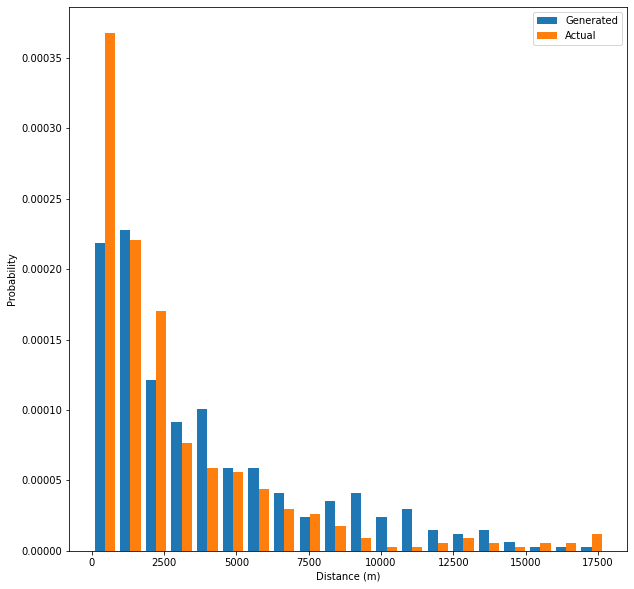

In [20]:
fig = plt.figure(figsize=(10, 10))
x = results_df["actual_stops_sp_length"]
y = results_df["gen_stops_sp_length"]

#bins = np.linspace(-10, 10, 30)
bins = 20

plt.hist([x, y], bins, density=True, label=['Generated', 'Actual'])

#plt.hist(y, bins, alpha=0.5, density=True, label="Generated")
#plt.hist(x, bins, alpha=0.5, density=True, label="Actual")
plt.xlabel('Distance (m)')
plt.ylabel('Probability')
plt.legend(loc="upper right")
plt.show();

Find the distance covered by the actual and generated bus routes so that fuel requirements can be calculated.

Load the original graph:

In [2]:
routes_graph = ox.load_graphml(filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")
route_nodes, route_edges = ox.graph_to_gdfs(routes_graph)

# string to bool
bool_replace = {"True": True, "False": False}
route_nodes["community_route"] = route_nodes["community_route"].map(bool_replace).fillna(False)
route_nodes["connection_route"] = route_nodes["connection_route"].map(bool_replace).fillna(False)
route_nodes["actual_stop"] = route_nodes["actual_stop"].map(bool_replace).fillna(False)

# ensure ints where expected
route_nodes["community_route_order"] = route_nodes["community_route_order"].astype(int)
route_nodes

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order,highway
2114650326,55.057663,-7.403884,2114650326,0,0.0002304475544637878,POINT (-7.40388 55.05766),0,0,False,32,False,False,NaN,NaN,NaN,NaN
2114650363,55.058671,-7.401458,2114650363,0,0.0005012166713618143,POINT (-7.40146 55.05867),14,0,True,36,False,False,NaN,NaN,NaN,NaN
2114650574,55.065282,-7.431412,2114650574,0,0.00039074531890811445,POINT (-7.43141 55.06528),0,0,True,24,False,False,NaN,NaN,NaN,NaN
2114650603,55.056001,-7.403478,2114650603,0,0.0002147939880001362,POINT (-7.40348 55.05600),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
258442518,55.132364,-7.454354,258442518,0,0.00020807192473270327,POINT (-7.45435 55.13236),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895464217,55.022280,-8.301011,1895464217,9,0.00020824925797252749,POINT (-8.30101 55.02228),0,0,True,44,False,False,NaN,NaN,NaN,NaN
1878490428,54.931667,-8.419818,1878490428,9,0.00028288951702548035,POINT (-8.41982 54.93167),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
1878490444,54.929254,-8.441124,1878490444,9,0.00028813735045901657,POINT (-8.44112 54.92925),0,0,False,-1,False,True,NaN,NaN,LL15-4,NaN
1895464579,55.022001,-8.320247,1895464579,9,0.0001534778486489186,POINT (-8.32025 55.02200),0,0,False,36,False,False,NaN,NaN,NaN,NaN


Generated routes

Community:

Get community route nodes and sort by route order

In [3]:
community_labels = list(route_nodes["community"].unique())
community_labels = [x for x in community_labels if str(x) != "nan"]
community_labels

['0', '1', '10', '11', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
community_route_nodes = []
for label in community_labels:
    nodes = route_nodes[(route_nodes["community"] == label) &
                        (route_nodes["community_route_order"] != -1)]
    nodes = nodes.sort_values(by="community_route_order")
    print(nodes)
    community_route_nodes.append(nodes)
len(community_route_nodes)

                    y         x       osmid community                    rank  \
262459232   55.116530 -7.460112   262459232         0   0.0006952453004233725   
2110993824  55.108519 -7.468899  2110993824         0  0.00012637731175985182   
2112562727  55.104847 -7.472255  2112562727         0  0.00019422346858492885   
2112562550  55.104540 -7.472658  2112562550         0  0.00023191885408507408   
258440720   55.102323 -7.475625   258440720         0  0.00025243842682268344   
2112562637  55.099784 -7.477446  2112562637         0  0.00026320998428031267   
2112562834  55.098461 -7.477632  2112562834         0   0.0002677939289857593   
2114692416  55.090521 -7.477590  2114692416         0   0.0002678747581426052   
258430807   55.090303 -7.477391   258430807         0   0.0002635385422318902   
2739577689  55.088130 -7.473974  2739577689         0   0.0002530695079664303   
2114692276  55.087741 -7.472854  2114692276         0    0.000233162586979399   
1979831232  55.087395 -7.471

14

Get the path of each community route

In [5]:
community_route_paths = [nodes["osmid"].tolist() for nodes in community_route_nodes]
len(community_route_paths)

14

Connections:

Get connection route nodes and sort by route order

In [6]:
route_nodes[route_nodes["osmid"] == 1279748374]

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order,highway
1279748374,54.706386,-8.723325,1279748374,4,0.00017664263353640952,POINT (-8.72333 54.70639),0,0,False,-1,False,False,a,a-2,NaN,NaN


In [7]:
connection_labels = ["a", "b", "c", "d"]
connection_route_nodes = []
connections = route_nodes[~route_nodes["connection"].isna()]
for label in connection_labels:
    nodes = connections[connections["connection"].str.contains(label)]
    # get correct connection order
    nodes["connection_order"] = nodes['connection_order'].str.extract(fr'{label}-(\d+)').astype(int)
    nodes.sort_values(by="connection_order", inplace=True)
    print(len(nodes))
    print(nodes)
    connection_route_nodes.append(nodes)
len(connection_route_nodes)

111
                    y         x       osmid community                    rank  \
2031126838  54.700451 -8.714760  2031126838         4   0.0006252125397542372   
507651123   54.706136 -8.724546   507651123         4  0.00018472189722861063   
1279748374  54.706386 -8.723325  1279748374         4  0.00017664263353640952   
2031154660  54.706664 -8.721967  2031154660         4   0.0002892484220071071   
1994336918  54.708648 -8.718380  1994336918         4  0.00023710239609514865   
...               ...       ...         ...       ...                     ...   
2012372598  54.835305 -8.442197  2012372598         5  0.00018460086528664015   
3578705391  54.836965 -8.444232  3578705391         5  0.00017134918887561234   
1956322707  54.836991 -8.444260  1956322707         5  0.00011978364995745125   
324742301   54.837298 -8.444637   324742301         5   0.0005905778203008173   
504701424   54.838289 -8.452235   504701424         5   0.0005909948387135886   

                       

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
<ipython-input-7-36e060477f0e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes.sort_values(by="connection_order", inplace=True)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

4

Get the path of each connection route

In [8]:
connection_route_paths = [nodes["osmid"].tolist() for nodes in connection_route_nodes]
len(connection_route_paths)

4

In [11]:
all_gen_paths = community_route_paths + connection_route_paths
path_weights = [route_helper.path_weight(routes_graph, path, weight="length")
                    for path in all_gen_paths]
path_weights

[19575.177,
 61154.988000000005,
 25291.327999999994,
 33383.246,
 27342.200999999997,
 44600.70400000003,
 34328.91100000001,
 46496.907,
 41397.379,
 57503.60300000001,
 34856.808,
 39370.028,
 53245.745000000024,
 17360.444,
 81734.72899999999,
 71102.66900000001,
 74931.36200000002,
 40648.18500000001]

In [ ]:
routes = [actual_stops_shortest_path, gen_stops_shortest_path]
rc = ['r', 'y']
fig, ax = ox.plot_graph_routes(test, routes,
                               route_colors=rc,
                               route_linewidth=6,
                               node_size=0)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sample_node = nodes[nodes["osmid"] == sample_nodes[300]]
gen_stops = nodes[nodes["community_route"] == True]
ll_stops = nodes[nodes["actual_stop"] == True]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

ll_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

sample_node.plot(
    ax=ax,
    marker=7,
    markersize=200,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

In [ ]:
##################
# analysis  - mean distance to a bus stop in either system
#           -